# Коллаборативная фильтрация

Коллаборативная фильтрация основана на идее, что пользователей, похожих на меня, можно использовать для прогнозирования того, насколько мне понравится тот или иной продукт или услуга, которые эти пользователи испытали на себе, а я - нет.

In [6]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357284 sha256=46f38ffe7d5f3f3751bba2e8fb25e57dc6e7f316a02cb07ad45f3415255d51bb
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [7]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import KNNBasic
from surprise import accuracy
from surprise import SlopeOne

from surprise.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV

In [8]:
reader = Reader()
ratings = pd.read_csv('/content/clear_rt.csv')
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
ratings.head()

,userId,movieId,rating,timestamp,id,title,film_link,average_rating,description,vote_count
0,1,1371,2.5,1260759135,1371,Rocky III,NaN,6.6,"Now the world champion, Rocky Balboa is living...",894.0
1,1,1405,1.0,1260759203,1405,Greed,NaN,7.5,Greed is the classic 1924 silent film by Erich...,25.0
2,1,2105,4.0,1260759139,2105,American Pie,NaN,6.4,"At a high-school party, four friends find that...",2358.0
3,1,2193,2.0,1260759198,2193,My Tutor,http://www.crownintlpictures.com/lntitles.html,5.8,High school senior Bobby Chrystal fails his Fr...,17.0
4,1,2294,2.0,1260759108,2294,Jay and Silent Bob Strike Back,NaN,6.4,When Jay and Silent Bob learn that their comic...,491.0


Буду тестировать разные модели из surprise - библиотека, предназначенная для построения и анализа рекомендательных систем:
* Загружаем датасет.
* Проводим кросс-валидацию. Кросс-валидация — это метод оценки производительности модели на разных подмножествах данных, чтобы оценить насколько хорошо она будет работать на новых данных. Будем использовать 5-кратную кросс-валидацию: данные будут разделены на 5 частей, и модель будет обучена на 4 из них и протестирована на оставшейся 5-й, и это будет повторено 5 раз, чтобы все 5 частей послужили тестовыми.
* Обучаем модель.
* Предсказываем.

## SVD

SVD - это метод линейной алгебры, который используется для разложения матрицы на три другие матрицы. В нашем случае, SVD используется для уменьшения размерности матрицы пользователь-фильм.

Как SVD работает в рекомендательных системах:
1.  Матрица пользователь-фильм: Исходные данные представляются в виде матрицы, где строки — пользователи, столбцы — фильмы, и ячейки содержат известные рейтинги.
2.  Сингулярное разложение: Матрица разлагается на три:
    * Матрица пользователей: Представляет пользователей в векторном пространстве. Каждый ряд соответствует пользователю, а столбцы - факторам, которые могут влиять на предпочтения пользователя (например, фактор "любит драму", "любит комедии").
    * Диагональная матрица сингулярных значений: Содержит сингулярные значения, которые указывают на важность каждого фактора. Значения упорядочены по убыванию.
    * Транспонированная матрица фильмов: Представляет фильмы в векторном пространстве. Каждый столбец соответствует фильму, а строки - факторам, аналогичным факторам из матрицы пользователей.
3.  Уменьшение размерности: Оставляют только самые важные факторы (сингулярные значения) из матрицы сингулярных значений, тем самым сокращая размерность матриц пользователей и фильмов.
4.  Восстановление матрицы: Используя урезанные матрицы, можно восстановить (приблизить) исходную матрицу рейтингов.
5.  Предсказание: Предсказанные рейтинги используются для рекомендации фильмов пользователям.

In [ ]:
svd = SVD()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()

prediction = svd.predict(1, 302, 3)
print(f"SVD Prediction for user 1 and movie 302: {prediction.est:.2f}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9022  0.8965  0.8987  0.8891  0.9011  0.8975  0.0046  
MAE (testset)     0.6917  0.6931  0.6948  0.6831  0.6956  0.6917  0.0045  
Fit time          7.30    8.94    7.07    8.05    8.66    8.01    0.73    
Test time         1.31    2.68    1.38    1.66    1.14    1.63    0.55    
SVD Prediction for user 1 and movie 302: 2.81


## KNNBasic

KNNBasic — это метод, который делает предсказания на основе рейтингов K пользователей, наиболее похожих на текущего пользователя. Он относится к группе алгоритмов "на основе памяти", потому что модель хранит все данные (чаще всего, после преобразования в матрицу схожести) и делает вычисления на основе этих данных, в отличие от алгоритмов "на основе модели", которые строят модель из данных (SVD).

Как KNNBasic работает:

1. Расчет схожести:
  * Вычисляется схожесть между всеми парами пользователей.
  * Используется pearson_baseline (в моем коде). Это модифицированный коэффициент корреляции Пирсона, который учитывает базовые рейтинги пользователей при расчете схожести, что обычно повышает точность. Базовый рейтинг пользователя - это средний рейтинг, который он ставит всем фильмам.
2. Поиск K ближайших соседей:
  * Для текущего пользователя выбираются K пользователей, которые имеют наибольшую схожесть.
3. Предсказание рейтинга:
  * Рейтинг для текущего пользователя и фильма предсказывается на основе рейтингов его K ближайших соседей.

In [11]:
import pickle
sim_options = {'name': 'pearson_baseline', 'user_based': True}
knn = KNNBasic(sim_options=sim_options)

cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()

prediction = knn.predict(8888, 302, 3)


print(f"KNN Prediction for user 1 and movie 302: {prediction.est:.2f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9943  0.9922  0.9878  0.9830  0.9732  0.9861  0.0075  
MAE (testset)     0.7708  0.7662  0.7665  0.7611  0.7525  0.7634  0.0063  
Fit time          0.17    0.16    0.33    0.41    0.58    0.33    0.16    
Test time         0.69    1.30    1.65    2.61    2.14  

NameError: name 'pickle' is not defined

In [13]:
import pickle

with open('model_12_15.pkl', 'wb') as file:
        pickle.dump(knn, file)
print("Модель экспортирована в файл 'model.......pkl'")

Модель экспортирована в файл 'model.......pkl'


## SlopeOne

SlopeOne — это алгоритм рекомендательных систем, основанный на сравнении разностей рейтингов между парами предметов (фильмов).

Как работает SlopeOne:

1. Расчет разностей рейтингов:
    * Для каждой пары фильмов вычисляется средняя разность рейтингов, которые поставили им пользователи.
    * Эти разности сохраняются в матрицу разностей.
2. Предсказание рейтинга:
    * Чтобы предсказать рейтинг пользователя для фильма, алгоритм берет рейтинги, которые этот пользователь поставил другим фильмам, и добавляет к ним средние разности между этими фильмами и фильмом, который нужно предсказать.
    * Предсказанный рейтинг является средним из всех этих "скорректированных" рейтингов.
    * Если есть несколько фильмов, которые пользователь оценил, то аналогичные вычисления проводятся для всех этих фильмов, и затем результаты усредняются.

In [ ]:
slope_one = SlopeOne()
cross_validate(slope_one, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()

prediction = slope_one.predict(1, 302, 3)
print(f"SlopeOne Prediction for user 1 and movie 302: {prediction.est:.2f}")

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9229  0.9341  0.9313  0.9316  0.9252  0.9290  0.0042  
MAE (testset)     0.7079  0.7145  0.7128  0.7136  0.7092  0.7116  0.0026  
Fit time          2.46    3.37    2.58    2.64    2.54    2.72    0.33    
Test time         4.74    4.52    4.34    4.52    4.49    4.52    0.13    
SlopeOne Prediction for user 1 and movie 302: 2.54


### Подбор гиперпараметров для SVD

In [ ]:
param_grid = {
    'n_factors': [50, 100, 150],
    'reg_all': [0.02, 0.1, 0.5]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

print("Best RMSE:", gs.best_score['rmse'])
print("Best MAE:", gs.best_score['mae'])
print("Best parameters:", gs.best_params['rmse'])

best_svd_rmse = gs.best_estimator['rmse']

trainset = data.build_full_trainset()
best_svd_rmse.fit(trainset)

prediction = best_svd_rmse.predict(1, 302, 2.5)
print(f"Prediction: {prediction.est:.2f}")

Best RMSE: 0.8910287090640056
Best MAE: 0.687439718534794
Best parameters: {'n_factors': 50, 'reg_all': 0.1}
Prediction: 2.73


* n_factors (количество факторов): Это количество *скрытых факторов*, которые SVD использует для представления пользователей и фильмов.
* reg_all (регуляризация всех параметров): Это параметр, который контролирует *регуляризацию*, которая применяется ко всем параметрам модели.
Регуляризация — это техника, которая помогает предотвратить *переобучение* модели. Она как бы "штрафует" модель за слишком большие или сложные параметры, заставляя её находить более простые и обобщающие решения.
* lr_all (скорость обучения): Это параметр, который контролирует, насколько сильно параметры модели обновляются на каждой итерации обучения. Алгоритм обучения SVD постепенно меняет параметры модели, чтобы сделать предсказания более точными. lr_all определяет, на сколько сильно параметры обновляются на каждой итерации.
* n_epochs (количество эпох): Это количество раз, которое алгоритм SVD проходит через все тренировочные данные в процессе обучения.
Что это такое: Каждая эпоха — это один проход по всему набору данных для обучения модели.

In [ ]:
def train_and_evaluate(data, n_iter=10):

    param_distributions = {
        'n_factors': randint(20, 200),
        'reg_all': uniform(0.01, 0.5),
        'lr_all': uniform(0.002, 0.02),
        'n_epochs': randint(10, 50)
    }

    rs = RandomizedSearchCV(SVD, param_distributions, measures=['rmse', 'mae'], cv=5, n_iter=n_iter)
    rs.fit(data)

    print("Best RMSE:", rs.best_score['rmse'])
    print("Best MAE:", rs.best_score['mae'])
    print("Best parameters (RMSE):", rs.best_params['rmse'])
    print("Best parameters (MAE):", rs.best_params['mae'])

    best_rmse = rs.best_score['rmse']
    best_mae = rs.best_score['mae']
    best_params_rmse = rs.best_params['rmse']
    best_params_mae = rs.best_params['mae']
    best_svd_rmse = rs.best_estimator['rmse']
    best_svd_mae = rs.best_estimator['mae']

    trainset = data.build_full_trainset()
    best_svd_rmse.fit(trainset)
    best_svd_mae.fit(trainset)

    return {
        'best_rmse': best_rmse,
        'best_mae': best_mae,
        'best_params_rmse': best_params_rmse,
        'best_params_mae': best_params_mae,
        'model_rmse': best_svd_rmse,
        'model_mae': best_svd_mae
    }


num_runs = 5
results = []

# Запускаем обучение и оценку несколько раз
for i in range(num_runs):
    print(f"Run {i+1}/{num_runs}")
    result = train_and_evaluate(data, n_iter=10)
    results.append(result)


Run 1/5
Best RMSE: 0.8845886068824523
Best MAE: 0.6823396790926728
Best parameters (RMSE): {'lr_all': 0.0152356581331288, 'n_epochs': 20, 'n_factors': 120, 'reg_all': 0.13516352219691535}
Best parameters (MAE): {'lr_all': 0.0152356581331288, 'n_epochs': 20, 'n_factors': 120, 'reg_all': 0.13516352219691535}
Run 2/5
Best RMSE: 0.8825978135804469
Best MAE: 0.6791322398987357
Best parameters (RMSE): {'lr_all': 0.014524748165272116, 'n_epochs': 13, 'n_factors': 179, 'reg_all': 0.05750356368218917}
Best parameters (MAE): {'lr_all': 0.014524748165272116, 'n_epochs': 13, 'n_factors': 179, 'reg_all': 0.05750356368218917}
Run 3/5
Best RMSE: 0.8729471580300328
Best MAE: 0.6708102330982632
Best parameters (RMSE): {'lr_all': 0.012953500641312315, 'n_epochs': 44, 'n_factors': 91, 'reg_all': 0.09408867005221243}
Best parameters (MAE): {'lr_all': 0.012953500641312315, 'n_epochs': 44, 'n_factors': 91, 'reg_all': 0.09408867005221243}
Run 4/5
Best RMSE: 0.8785716626025932
Best MAE: 0.6751491243999539
Bes

In [ ]:
# Находим лучшие результаты среди всех запусков
best_rmse_run = min(results, key=lambda x: x['best_rmse'])
best_mae_run = min(results, key=lambda x: x['best_mae'])

# Выводим результаты
print("\nBest Results Overall:")
print(f"Best RMSE: {best_rmse_run['best_rmse']:.4f}")
print(f"Best parameters (RMSE): {best_rmse_run['best_params_rmse']}")
print(f"Best MAE: {best_mae_run['best_mae']:.4f}")
print(f"Best parameters (MAE): {best_mae_run['best_params_mae']}")

# Выводим предсказания
prediction_rmse = best_rmse_run['model_rmse'].predict(1, 302, 2.5)
prediction_mae = best_mae_run['model_mae'].predict(1, 302, 2.5)

print(f"Prediction (Best RMSE model): {prediction_rmse.est:.2f}")
print(f"Prediction (Best MAE model): {prediction_mae.est:.2f}")


Best Results Overall:
Best RMSE: 0.8729
Best parameters (RMSE): {'lr_all': 0.012953500641312315, 'n_epochs': 44, 'n_factors': 91, 'reg_all': 0.09408867005221243}
Best MAE: 0.6708
Best parameters (MAE): {'lr_all': 0.012953500641312315, 'n_epochs': 44, 'n_factors': 91, 'reg_all': 0.09408867005221243}
Prediction (Best RMSE model): 2.76
Prediction (Best MAE model): 2.83


### Итоговая модель:


In [ ]:
best_params_rmse = {'lr_all': 0.012953500641312315, 'n_epochs': 44, 'n_factors': 91, 'reg_all': 0.09408867005221243}
best_params_mae = {'lr_all': 0.012953500641312315, 'n_epochs': 44, 'n_factors': 91, 'reg_all': 0.09408867005221243}

# Инициализация SVD с лучшими параметрами (RMSE)
svd = SVD(
    lr_all=best_params_rmse['lr_all'],
    n_epochs=best_params_rmse['n_epochs'],
    n_factors=best_params_rmse['n_factors'],
    reg_all=best_params_rmse['reg_all']
)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()

prediction = svd.predict(1, 302, 3)
print(f"SVD Prediction for user 1 and movie 302: {prediction.est:.2f}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8695  0.8800  0.8774  0.8730  0.8725  0.8745  0.0037  
MAE (testset)     0.6676  0.6752  0.6747  0.6674  0.6727  0.6715  0.0034  
Fit time          16.34   17.81   15.82   15.81   15.70   16.30   0.79    
Test time         2.96    1.34    1.22    1.44    1.14    1.62    0.68    
SVD Prediction for user 1 and movie 302: 2.88


### Топ 30 фильмов для пользователя

In [ ]:
def get_top_n_recommendations(model, user_id, data, n=30):
    all_movie_ids = data.df['movieId'].unique()
    rated_movie_ids = data.df[data.df['userId'] == user_id]['movieId'].unique()

    unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movie_ids)

    predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movie_ids]

    predictions.sort(key=lambda x: x.est, reverse=True)

    top_n_movie_ids = [pred.iid for pred in predictions[:n]]
    return top_n_movie_ids


In [ ]:
user_id_to_recommend = 1

top_30_movies = get_top_n_recommendations(best_svd_rmse, user_id_to_recommend, data, n=30)
print(f"Top 30 movies for user {user_id_to_recommend}: {top_30_movies}")

Top 30 movies for user 1: [858, 318, 913, 7502, 969, 926, 1221, 2064, 3462, 5971, 904, 50, 899, 905, 78499, 1252, 106782, 1254, 26729, 1276, 2917, 2019, 1060, 3730, 307, 2300, 1228, 246, 1203, 1945]


In [25]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import pickle
#userId	movieId	rating

# 1. Загрузка и подготовка данных
def prepare_data(rating_df):
    """
    Преобразует DataFrame с оценками в разреженную матрицу пользователь-фильм.
    :param rating_df: DataFrame с полями ['userId', 'movid', 'rating'].
    :return: разреженная матрица пользователь-фильм, индексы фильмов и пользователей.
    """
    user_movie_matrix = rating_df.pivot(index='movieId', columns='userId', values='rating').fillna(0)
    sparse_matrix = csr_matrix(user_movie_matrix)
    return sparse_matrix, user_movie_matrix.index, user_movie_matrix.columns

# 2. Обучение KNN модели
def train_knn_model(sparse_matrix, n_neighbors=10):
    """
    Обучает KNN модель на основе косинусной схожести.
    :param sparse_matrix: разреженная матрица пользователь-фильм.
    :param n_neighbors: количество ближайших соседей.
    :return: обученная KNN модель.
    """
    model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors)
    model.fit(sparse_matrix)
    return model

# 3. Рекомендации для нового пользователя
def recommend_movies_for_new_user(favorite_movies, knn_model, sparse_matrix, movie_indices, top_n=20):
    """
    Рекомендует фильмы для нового пользователя на основе KNN.
    :param favorite_movies: список ID фильмов нового пользователя.
    :param knn_model: обученная KNN модель.
    :param sparse_matrix: разреженная матрица пользователь-фильм.
    :param movie_indices: индексы фильмов в матрице.
    :param top_n: количество фильмов для рекомендаций.
    :return: список рекомендованных фильмов.
    """
    movie_id_to_index = {movie: idx for idx, movie in enumerate(movie_indices)}
    favorite_indices = [movie_id_to_index[movie] for movie in favorite_movies if movie in movie_id_to_index]

    similarity_scores = []
    for idx in favorite_indices:
        distances, indices = knn_model.kneighbors(sparse_matrix[idx], n_neighbors=top_n + len(favorite_movies))
        similarity_scores.extend(indices.flatten())

    # Подсчёт частоты появления фильмов среди соседей
    recommendation_counts = pd.Series(similarity_scores).value_counts()
    # Убираем фильмы, которые пользователь уже указал
    recommendation_counts = recommendation_counts[~recommendation_counts.index.isin(favorite_indices)]

    recommended_indices = recommendation_counts.nlargest(top_n).index
    recommended_movies = [movie_indices[i] for i in recommended_indices]
    return recommended_movies

# 4. Пример использования
if __name__ == "__main__":
    # Загрузка данных
    rating_small = pd.read_csv('/content/clear_rt.csv')  # Должен содержать ['userid', 'movid', 'rating']

    # Подготовка данных
    sparse_matrix, movie_indices, user_indices = prepare_data(rating_small)

    # Обучение модели KNN
    knn_model = train_knn_model(sparse_matrix, n_neighbors=10)
    with open('model_02_30.pkl', 'wb') as file:
        pickle.dump(knn_model, file)
    print("Модель экспортирована в файл 'model.......pkl'")
    # Новый пользователь: список его любимых фильмов (movid)
    new_user_favorite_movies = [234, 52, 53
                                , 10681, 12, 293310, 331781, 1430, 158999, 39452, 27205, 155, 76341, 49026, 680, 920, 2330, 77, 64682, 157336]

#[1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270]

    # Получение рекомендаций
    recommended_movies = recommend_movies_for_new_user(new_user_favorite_movies, knn_model, sparse_matrix, movie_indices, top_n=30)

    print("Рекомендации для нового пользователя:")
    print(recommended_movies)


Модель экспортирована в файл 'model.......pkl'
Рекомендации для нового пользователя:
[1543, 1731, 2800, 244, 2754, 3587, 2982, 1549, 1550, 3941, 1640, 137, 1696, 1715, 2189, 1771, 3041, 183, 1493, 3938, 526, 775, 980, 561, 1989, 108, 1990, 189, 2655, 1891]


In [24]:
rating_small = pd.read_csv('/content/clear_rt.csv')
rating_small.head()

,userId,movieId,rating,timestamp,id,title,film_link,average_rating,description,vote_count
0,1,1371,2.5,1260759135,1371,Rocky III,NaN,6.6,"Now the world champion, Rocky Balboa is living...",894.0
1,1,1405,1.0,1260759203,1405,Greed,NaN,7.5,Greed is the classic 1924 silent film by Erich...,25.0
2,1,2105,4.0,1260759139,2105,American Pie,NaN,6.4,"At a high-school party, four friends find that...",2358.0
3,1,2193,2.0,1260759198,2193,My Tutor,http://www.crownintlpictures.com/lntitles.html,5.8,High school senior Bobby Chrystal fails his Fr...,17.0
4,1,2294,2.0,1260759108,2294,Jay and Silent Bob Strike Back,NaN,6.4,When Jay and Silent Bob learn that their comic...,491.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
films.head()

,id,title,film_link,average_rating,description,vote_count
0,862,Toy Story,http://toystory.disney.com/toy-story,7.7,"Led by Woody, Andy's toys live happily in his ...",5415.0
1,8844,Jumanji,NaN,6.9,When siblings Judy and Peter discover an encha...,2413.0
2,15602,Grumpier Old Men,NaN,6.5,A family wedding reignites the ancient feud be...,92.0
3,31357,Waiting to Exhale,NaN,6.1,"Cheated on, mistreated and stepped on, the wom...",34.0
4,11862,Father of the Bride Part II,NaN,5.7,Just when George Banks has recovered from his ...,173.0


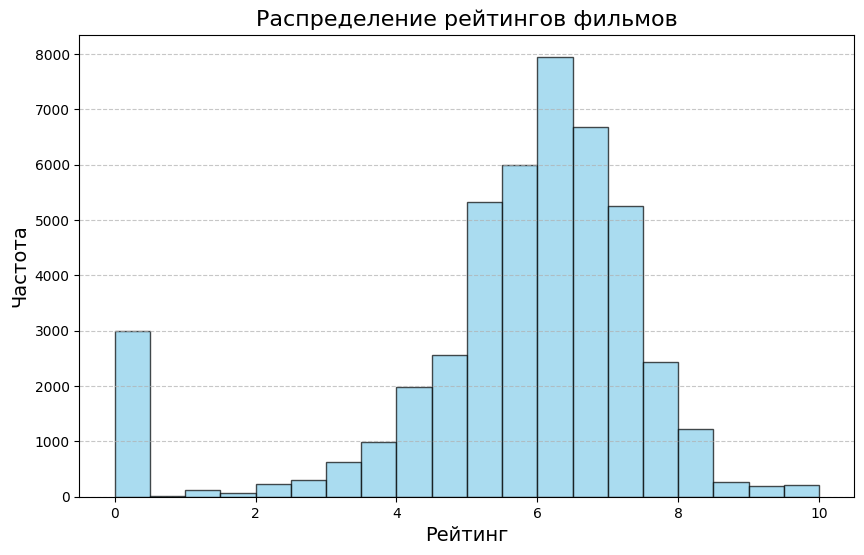

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet


rating_small = pd.read_csv('/content/clear_rt.csv')
films = pd.read_csv('/content/films.csv')

# Построение распределения
plt.figure(figsize=(10, 6))
plt.hist(films['average_rating'], bins=20, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Распределение рейтингов фильмов', fontsize=16)
plt.xlabel('Рейтинг', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показать график
plt.show()


In [2]:
films['description'] = films['description'].fillna('')

In [16]:
films.head(10)

,level_0,index,id,title,film_link,average_rating,description,vote_count
0,0,0,862,Toy Story,http://toystory.disney.com/toy-story,7.7,"Led by Woody, Andy's toys live happily in his ...",5415.0
1,1,1,8844,Jumanji,NaN,6.9,When siblings Judy and Peter discover an encha...,2413.0
2,2,2,15602,Grumpier Old Men,NaN,6.5,A family wedding reignites the ancient feud be...,92.0
3,3,3,31357,Waiting to Exhale,NaN,6.1,"Cheated on, mistreated and stepped on, the wom...",34.0
4,4,4,11862,Father of the Bride Part II,NaN,5.7,Just when George Banks has recovered from his ...,173.0
5,5,5,949,Heat,NaN,7.7,"Obsessive master thief, Neil McCauley leads a ...",1886.0
6,6,6,11860,Sabrina,NaN,6.2,An ugly duckling having undergone a remarkable...,141.0
7,7,7,45325,Tom and Huck,NaN,5.4,"A mischievous young boy, Tom Sawyer, witnesses...",45.0
8,8,8,9091,Sudden Death,NaN,5.5,International action superstar Jean Claude Van...,174.0
9,9,9,710,GoldenEye,http://www.mgm.com/view/movie/757/Goldeneye/,6.6,James Bond must unmask the mysterious head of ...,1194.0


In [11]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english', max_features=250000 )
tfidf_matrix = tf.fit_transform(films[:10000]['description'])
print(tfidf_matrix.shape)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

films = films.reset_index()
titles = films['title']
indices = pd.Series(films.index, index=films['title'])

(10000, 32353)


In [12]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [14]:
get_recommendations('Memento').head(10)

,title
8084,Novo
2509,After Life
653,Kids in the Hall: Brain Candy
901,Rebecca
473,Jimmy Hollywood
8046,The Woman in Green
6800,Gothika
7139,50 First Dates
3998,Leonard Part 6
6275,Oscar


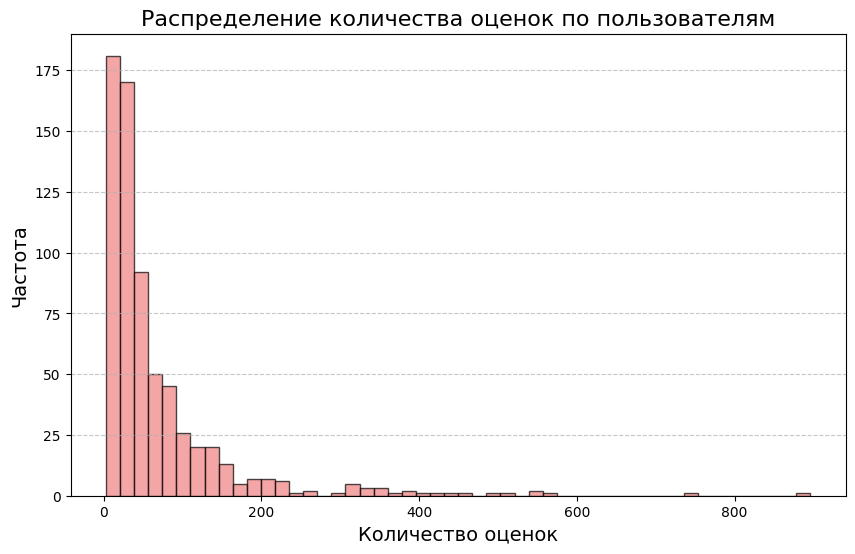

In [15]:
user_ratings_count = rating_small.groupby('userId').size()

# Построение графика распределения
plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count, bins=50, edgecolor='black', color='lightcoral', alpha=0.7)
plt.title('Распределение количества оценок по пользователям', fontsize=16)
plt.xlabel('Количество оценок', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

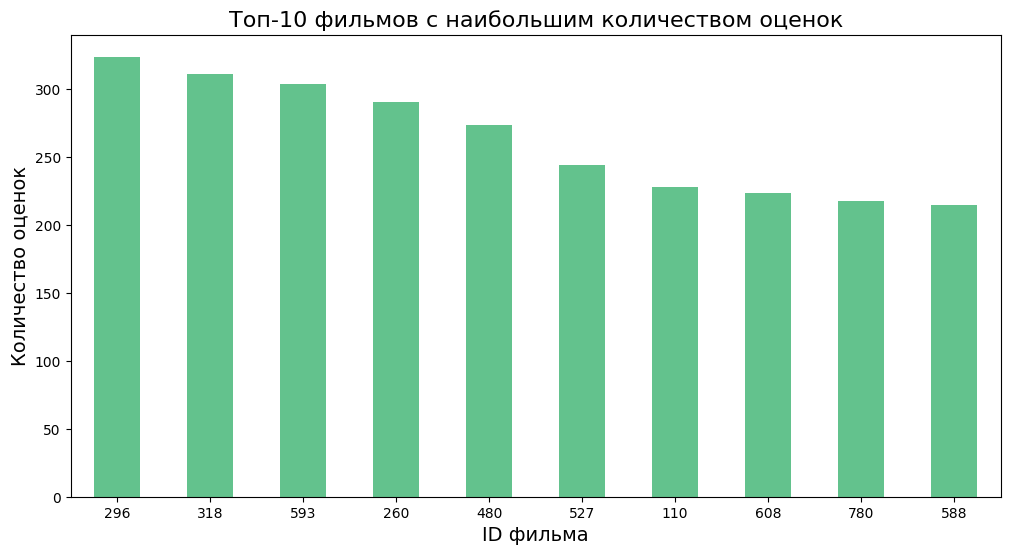

In [16]:
movie_ratings_count = ratings.groupby('movieId').size().sort_values(ascending=False)

# Топ-10 фильмов
top_10_movies = movie_ratings_count.head(10)

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
top_10_movies.plot(kind='bar', color='mediumseagreen', alpha=0.8)
plt.title('Топ-10 фильмов с наибольшим количеством оценок', fontsize=16)
plt.xlabel('ID фильма', fontsize=14)
plt.ylabel('Количество оценок', fontsize=14)
plt.xticks(rotation=0)
plt.show()

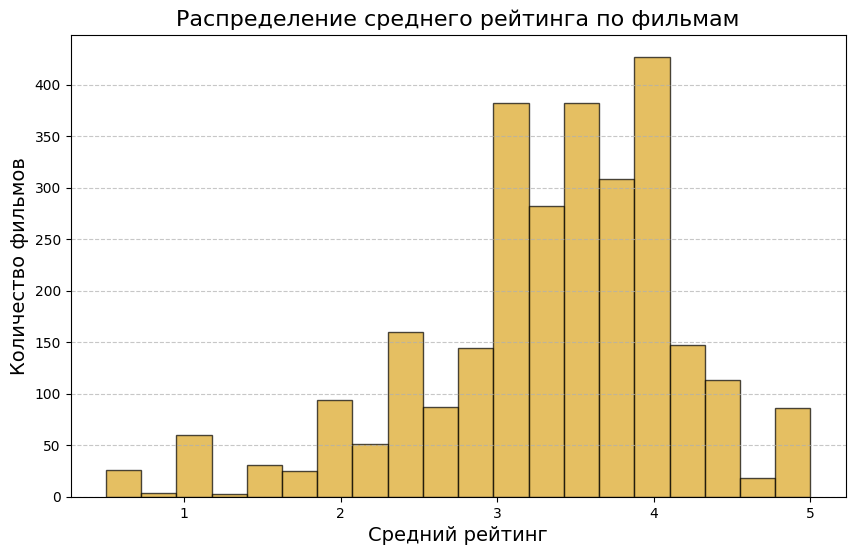

In [17]:
# Вычисление среднего рейтинга для каждого фильма
average_movie_rating = ratings.groupby('movieId')['rating'].mean()

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.hist(average_movie_rating, bins=20, edgecolor='black', color='goldenrod', alpha=0.7)
plt.title('Распределение среднего рейтинга по фильмам', fontsize=16)
plt.xlabel('Средний рейтинг', fontsize=14)
plt.ylabel('Количество фильмов', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
